In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import pandas as pd
import seaborn as sns
from sklearn import datasets as sk_ds
from sklearn import decomposition as sk_dc
from sklearn import metrics as sk_mtr
from sklearn import model_selection as sk_ms
from sklearn import pipeline as sk_pipe
from sklearn import preprocessing as sk_prep
from sklearn import svm as sk_svm


In [2]:
colors = list(mcolors.TABLEAU_COLORS.values())

# Features

In [3]:
def make_features(N, dim):
    X, y = sk_ds.make_blobs(
        n_samples=N, 
        n_features=dim,
        centers=3,
    )
    
    X = sk_prep.StandardScaler().fit_transform(X)

    X_tr, X_te, y_tr, y_te = sk_ms.train_test_split(
        X, y, train_size=0.6, stratify=y
    )
    return {
        'X': X, 'y': y,
        'X_train': X_tr, 'y_train': y_tr,
        'X_test': X_te, 'y_test': y_te,
    }


def visualize(ds):
    dim = ds['X'].shape[1]
    xy = [
        (ds['X'], ds['y']), 
        (ds['X_train'], ds['y_train']), 
        (ds['X_test'], ds['y_test']),
    ]
    
    if dim > 2:
        xy = [
            (sk_dc.PCA(n_components=2).fit_transform(x), y) 
            for x, y in xy
        ] 
    
    fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

    for idx, (xx, yy) in enumerate(xy):
        for v in range(max(ds['y']) + 1):
            x_c = xx[yy == v]
            x1, x2 = zip(*x_c)
            axs[idx].scatter(x1, x2, color=colors[v], label=v)
        axs[idx].legend()


def check_classification(X_train, y_train, X, y):
    lsvc = sk_svm.LinearSVC(max_iter=1e4)
    lsvc.fit(X_train, y_train)
    print(sk_mtr.classification_report(y_true=y, y_pred=lsvc.predict(X)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        22
           2       1.00      1.00      1.00        21

    accuracy                           1.00        65
   macro avg       1.00      1.00      1.00        65
weighted avg       1.00      1.00      1.00        65



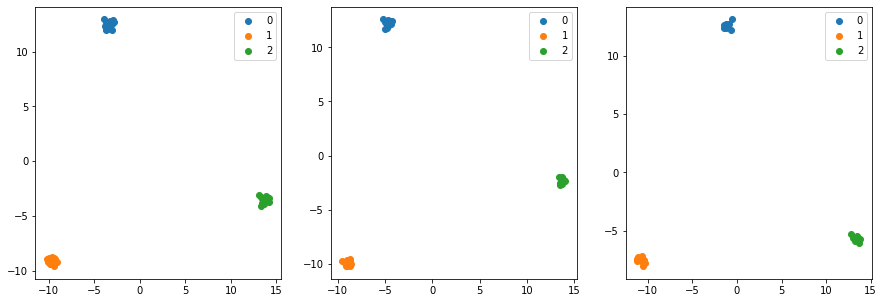

In [4]:
feature_dim = 200
fts = make_features(N=65, dim=feature_dim)
visualize(fts)
check_classification(fts['X_train'], fts['y_train'], fts['X'], fts['y'])


# Graph

In [5]:
import networkx as nx
import numpy as np

In [6]:
full_graph_size = 7
path_size = 7

print('Full graph edges:', nx.complete_graph(full_graph_size).number_of_edges())

g = nx.barbell_graph(m1=full_graph_size, m2=path_size)
print('Edges:', g.number_of_edges())

Full graph edges: 21
Edges: 50


In [7]:
left_graph_edges = [e for e in g.edges() if max(e) <= full_graph_size - 1]
right_graph_edges = [e for e in g.edges() if min(e) >= full_graph_size + path_size]
path_edges = [e for e in g.edges() if e not in left_graph_edges and e not in right_graph_edges]

print('L:', left_graph_edges)
print('R:', right_graph_edges)
print('P:', path_edges)

L: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 3), (2, 4), (2, 5), (2, 6), (3, 4), (3, 5), (3, 6), (4, 5), (4, 6), (5, 6)]
R: [(14, 15), (14, 16), (14, 17), (14, 18), (14, 19), (14, 20), (15, 16), (15, 17), (15, 18), (15, 19), (15, 20), (16, 17), (16, 18), (16, 19), (16, 20), (17, 18), (17, 19), (17, 20), (18, 19), (18, 20), (19, 20)]
P: [(6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14)]


/home/peter/venvs/egs/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


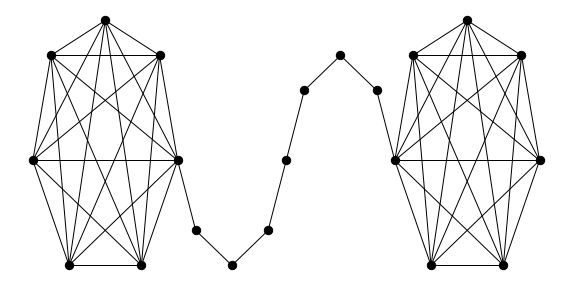

In [9]:
pos = {
    # Left graph
    0: (0, -3.5), 1: (2, -3.5), 2: (-1, -2), 6: (3, -2), 4: (-0.5, -0.5), 5: (2.5, -0.5), 3: (1, 0),
    # Path
    7: (3.5, -3), 8: (4.5, -3.5), 9: (5.5, -3), 
    10: (6, -2), 
    11: (6.5, -1), 12: (7.5, -0.5), 13: (8.5, -1),
    # Right graph
    16: (10, -3.5), 15: (12, -3.5), 14: (9, -2), 17: (13, -2), 18: (9.5, -0.5), 19: (12.5, -0.5), 20: (11, 0),
}


fig, ax = plt.subplots(figsize=(10, 5))
nx.draw(
    G=g, 
    pos=pos, 
    node_color='black',
    ax=ax,
    node_size=70,
)
#ax.set_aspect('equal')

# Assign features to graph

In [10]:
import pickle

def make_edge_classification_dataset(fts_ds, graph, le, pe, re):
    edges = []
    for u, v in graph.edges():
        edges.extend([(u, v), (v, u)])
    
    edges = sorted(edges)
    idxs = range(len(edges))

    edge2idx = dict(zip(edges, idxs))
    H = np.zeros(shape=(len(edges), feature_dim + 1))

    xe = []
    y = []
    feature_group = []

    for i, es in enumerate([le, pe, re]):
        for (u, v), fts in zip(es, fts_ds['X'][fts_ds['y'] == i]):
            H[edge2idx[(u, v)], :-1] = fts
            H[edge2idx[(u, v)], -1] = 1  # Mark as original edge
            
            H[edge2idx[(v, u)], :-1] = fts
            
            xe.append((u, v))
            y.append(i)
            feature_group.append(i)
            
    return {
        'edge2idx': edge2idx, 
        'H': H, 
        'xe': xe, 'y': y, 
        'feature_group': feature_group,
        'graph': graph,
        'num_cls': 3,
        'dims': {'node': 4, 'edge': feature_dim + 1}
    }

edge_ds = make_edge_classification_dataset(fts, g, left_graph_edges, path_edges, right_graph_edges)
print(edge_ds['xe'])
print(edge_ds['y'])
print(edge_ds['H'].shape)
print(edge_ds['graph'].number_of_nodes(), edge_ds['graph'].number_of_edges())

with open('../../data/ablation/data-mini.pkl', 'wb') as fout:
    pickle.dump(edge_ds, fout)

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 3), (2, 4), (2, 5), (2, 6), (3, 4), (3, 5), (3, 6), (4, 5), (4, 6), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (14, 16), (14, 17), (14, 18), (14, 19), (14, 20), (15, 16), (15, 17), (15, 18), (15, 19), (15, 20), (16, 17), (16, 18), (16, 19), (16, 20), (17, 18), (17, 19), (17, 20), (18, 19), (18, 20), (19, 20)]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
(100, 201)
21 50


/home/peter/venvs/egs/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \


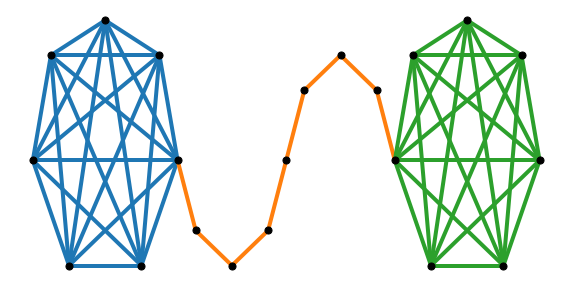

In [11]:
def visualize_graph(dataset, node_positions, ax, width=4, ns=50):
    ecolor = {e: colors[fid] for e, fid in zip(dataset['xe'], dataset['feature_group'])}
    
    nx.draw(
        G=dataset['graph'], 
        pos=node_positions, 
        node_color='black',
        ax=ax,
        node_size=ns,
        edge_color=[ecolor[e] for e in g.edges()], 
        width=width,
    )
    #ax.set_aspect('equal')


fig, ax = plt.subplots(figsize=(10, 5))
visualize_graph(edge_ds, pos, ax)

In [12]:
from copy import deepcopy


def shuffle_edges(dataset, p):
    ds = deepcopy(dataset)
    fg = ds['feature_group']
    y = ds['y']
    H = ds['H']
    
    edge_pairs = [
        (i, j) 
        for i in range(len(ds['xe'])) 
        for j in range(i + 1, len(ds['xe']))
        if y[i] != y[j]
    ]
    
    num_pairs = int(p * len(edge_pairs))
    
    pair_idxs = np.random.choice(len(edge_pairs), size=num_pairs, replace=False)
    
    for pidx in pair_idxs:
        i, j = edge_pairs[pidx]
        
        fg[i], fg[j] = fg[j], fg[i]
        y[i], y[j] = y[j], y[i]
        
        xe_i, xe_j = ds['xe'][i], ds['xe'][j]
        idx_i, idx_j = ds['edge2idx'][xe_i], ds['edge2idx'][xe_j]
        H[idx_i], H[idx_j] = deepcopy(H[idx_j]), deepcopy(H[idx_i])
        
        # swap also reverse edges
        idx_i_r, idx_j_r = ds['edge2idx'][(xe_i[1], xe_i[0])], ds['edge2idx'][(xe_j[1], xe_j[0])]
        H[idx_i_r], H[idx_j_r] = deepcopy(H[idx_j_r]), deepcopy(H[idx_i_r])

    return ds

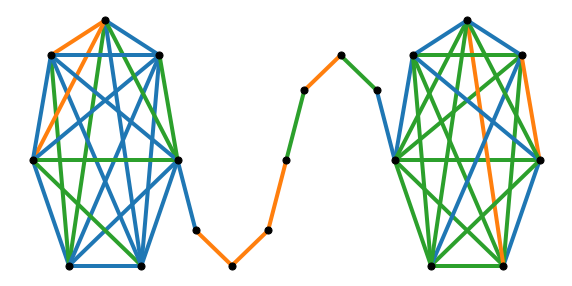

In [226]:
s_ds = shuffle_edges(edge_ds, p=0.05)
visualize_graph(s_ds, pos, plt.subplots(figsize=(10, 5))[1])

with open('../../data/ablation/data-mini-0.5.pkl', 'wb') as fout:
    pickle.dump(s_ds, fout)

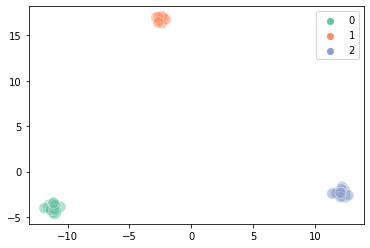

In [227]:
fts = [s_ds['H'][s_ds['edge2idx'][e]] for e in s_ds['xe']]

fig, ax = plt.subplots()
sns.scatterplot(
    *zip(*sk_dc.PCA(n_components=2).fit_transform(fts)),
     marker='.', s=500, alpha=0.5, palette='Set2', hue=s_ds['y'], ax=ax,
)

# Initial plot

### Node2vec

In [14]:
import node2vec as n2v


def run_node2vec(dataset):
    n2v_emb = n2v.Node2Vec(
        graph=dataset['graph'],
        dimensions=2,
        p=4, q=1,
    ).fit()

    eemb = np.array([
        np.mean([n2v_emb[str(u)], n2v_emb[str(v)]], axis=0) 
        for u, v in dataset['xe']
    ])
    
    return eemb


with open('../../data/ablation/initial/n2v.pkl', 'wb') as fout:
    pickle.dump(run_node2vec(edge_ds), fout)

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 14.78it/s]
/home/peter/venvs/egs/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


### Line2vec

In [24]:
# nx.write_edgelist(edge_ds['graph'], '../../l2v/data/barbell.edgelist')

def get_line2vec_embs(dataset):
    with open('../../data/ablation/initial/line2vec.pkl', 'rb') as fin:
        l2v_emb = pickle.load(fin)

    eemb = np.array([l2v_emb[e] for e in dataset['xe']])
    
    return eemb

### Plots

### AttrE2vec

In [25]:
import sys; sys.path.append('../..')

%load_ext autoreload
%autoreload 2

import paper_graph_utils as pgu

In [26]:
rws = pgu.make_random_walks(edge_ds, k=4, L=8)
with open('../../data/ablation/rws.pkl', 'wb') as fout:
    pickle.dump(rws, fout)

In [27]:
attre2_eemb_05, _ = pgu.run_model(dataset_name='data-mini', model_name='Avg', emb_dim=2, mixing=0.5, epochs=5)
attre2_eemb_0, _ = pgu.run_model(dataset_name='data-mini', model_name='Avg', emb_dim=2, mixing=0, epochs=5)
attre2_eemb_1, _ = pgu.run_model(dataset_name='data-mini', model_name='Avg', emb_dim=2, mixing=1, epochs=5)

INFO:lightning:GPU available: False, used: False


/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False


/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False


/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


In [229]:
attre2_eemb_s_05, _ = pgu.run_model(dataset_name='data-mini-0.5', model_name='Avg', emb_dim=2, mixing=0.5, epochs=15)
attre2_eemb_s_0, _ = pgu.run_model(dataset_name='data-mini-0.5', model_name='Avg', emb_dim=2, mixing=0, epochs=15)
attre2_eemb_s_1, _ = pgu.run_model(dataset_name='data-mini-0.5', model_name='Avg', emb_dim=2, mixing=1, epochs=15)

INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.6
AUC: 0.6729885057471264
F1: 0.5613275613275613
CM: [[14  1  6]
 [ 3  3  2]
 [ 6  2 13]]


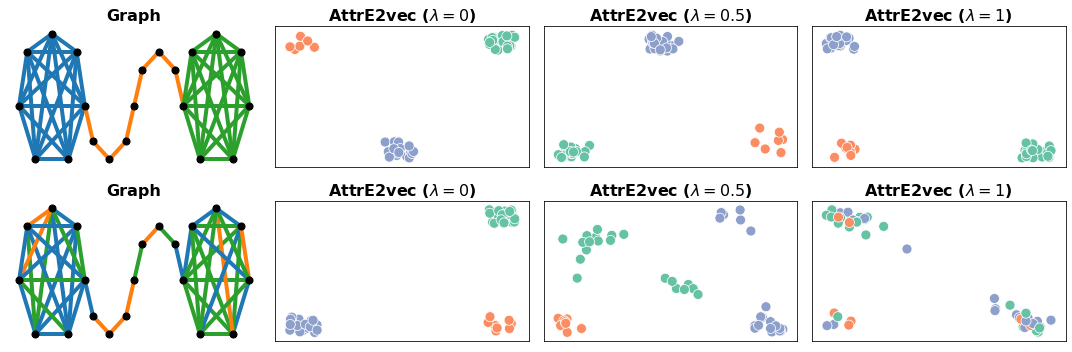

In [295]:
# Read embeddings
with open('../../data/ablation/initial/n2v.pkl', 'rb') as fin:
    n2v_eemb = pickle.load(fin)
    
l2v_eemb = get_line2vec_embs(edge_ds)

attre2 = [
    [attre2_eemb_0, attre2_eemb_05, attre2_eemb_1],
    [attre2_eemb_s_0, attre2_eemb_s_05, attre2_eemb_s_1],
]
    

# Prepare plots
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15, 5))

for idx, dataset in enumerate((edge_ds, s_ds)):
    labels = dataset['y']
    
    visualize_graph(dataset, pos, axs[idx, 0])
    axs[idx, 0].set_title('Graph', size=16, weight='bold')

    titles = [
#         'Node2vec', 
#         'Line2vec', 
        'AttrE2vec ($\lambda = 0$)', 
        'AttrE2vec ($\lambda = 0.5$)', 
        'AttrE2vec ($\lambda = 1$)',
    ]
    
#     models = [n2v_eemb, l2v_eemb, *attre2[idx]]
    models = attre2[idx]
    
    for title, eemb, ax in zip(titles, models, axs[idx, 1:]):
        if 'AttrE2vec' in title:
            eemb = eemb + 0.3 * np.random.uniform(size=eemb.shape)
        
        sns.scatterplot(*zip(*eemb), marker='o', s=100, palette='Set2', hue=labels, ax=ax)
        ax.legend_.remove()
        ax.set_title(title, size=16, weight='bold')
        ax.set(xticks=[], yticks=[])
        #ax.axis('off')

fig.tight_layout()
fig.savefig('../../data/ablation/initial-figure-v2.png')

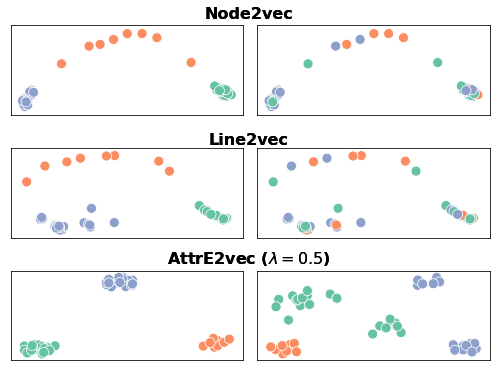

In [290]:
# fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(7, 10))
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(7, 5))

attre2 = [
    #[attre2_eemb_0, attre2_eemb_05, attre2_eemb_1],
    #[attre2_eemb_s_0, attre2_eemb_s_05, attre2_eemb_s_1],
    attre2_eemb_05, attre2_eemb_s_05,
]

for idx, dataset in enumerate((edge_ds, s_ds)):
    labels = dataset['y']
    
#     visualize_graph(dataset, pos, axs[0, idx], width=2, ns=10)
    #axs[0, idx].set_title('Graph', size=16, weight='bold')

    titles = [
        'Node2vec', 
        'Line2vec', 
        #'AttrE2vec ($\lambda = 0$)', 
        'AttrE2vec ($\lambda = 0.5$)', 
        #'AttrE2vec ($\lambda = 1$)',
    ]
    
#     models = [n2v_eemb, l2v_eemb, *attre2[idx]]
    models = [n2v_eemb, l2v_eemb, attre2[idx]]
    
    for title, eemb, ax in zip(titles, models, axs[:, idx]):
        if 'AttrE2vec' in title:
            eemb = eemb + 0.3 * np.random.uniform(size=eemb.shape)
        
        sns.scatterplot(*zip(*eemb), marker='o', s=100, palette='Set2', hue=labels, ax=ax)
        ax.legend_.remove()
        #ax.set_title(title, size=16, weight='bold')
        ax.set(xticks=[], yticks=[])
    
    title_kwargs = dict(va="center", ha="center", size=16, weight='bold')
#     plt.figtext(0.5, 1, "Node2vec", **title_kwargs)
#     plt.figtext(0.5, 0.80, "Line2vec", **title_kwargs)
#     plt.figtext(0.5, 0.60, "AttrE2vec ($\lambda = 0$)", **title_kwargs)
#     plt.figtext(0.5, 0.40, "AttrE2vec ($\lambda = 0.5$)", **title_kwargs)
#     plt.figtext(0.5, 0.20, "AttrE2vec ($\lambda = 1$)", **title_kwargs)

    plt.figtext(0.5, 1, "Node2vec", **title_kwargs)
    plt.figtext(0.5, 0.65, "Line2vec", **title_kwargs)
    plt.figtext(0.5, 0.32, "AttrE2vec ($\lambda = 0.5$)", **title_kwargs)

# fig.tight_layout(h_pad=4.0)
fig.tight_layout(h_pad=3.0)
fig.savefig('../../data/ablation/initial-figure-vert.png', bbox_inches='tight')

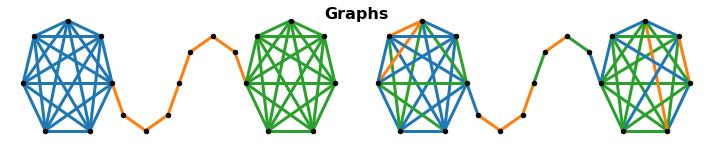

In [237]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 2))

for idx, dataset in enumerate((edge_ds, s_ds)):    
    visualize_graph(dataset, pos, axs[idx], width=3, ns=20)
    fig.suptitle('Graphs', weight='bold', size=16)

    
fig.tight_layout()
fig.savefig('../../data/ablation/initial-figure-vert-graphs.png')

# Ablation

In [34]:
from IPython.display import display
from tqdm.auto import tqdm

In [38]:
# probs = [0, 0.25, 0.5, 0.75, 1.0]
probs = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

lambdas = [0, 0.5, 1.0]
#lambdas = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [279]:
def run_ablation(fn=shuffle_edges, retrains=10):
    epochs = 10

    res = {}

    for p in tqdm(probs, desc='probs'):
        for mixing in tqdm(lambdas, desc='mixing', leave=False):
            res[(p, mixing)] = []
            for _ in tqdm(range(retrains), desc='retrain', leave=False):
                with open('../../data/ablation/data-ablation.pkl', 'wb') as fout:
                    pickle.dump(fn(edge_ds, p=p), fout)

                _, auc = pgu.run_model(
                    dataset_name='data-ablation', 
                    model_name='Avg', 
                    emb_dim=2, 
                    mixing=mixing, 
                    epochs=epochs,
                )

                res[(p, mixing)].append(auc)

    return res


def make_ablation_summary(r, n=10):
    res_ms = {
        k: {
            'mean': np.round(np.mean(v[:n]) * 100., 2), 
            'std': np.round(np.std(v[:n]) * 100., 2),
        } for k, v in r.items()
    }
    
    fig, ax = plt.subplots(figsize=(8, 5))

    for idx, mixing in enumerate(lambdas):
        x = probs
        means = np.array([res_ms[(p, mixing)]['mean'] for p in probs])
        stds = np.array([res_ms[(p, mixing)]['std'] for p in probs])

        ax.plot(x, means, linestyle='--', marker='x', label=f'$\lambda$ = {mixing}', color=colors[idx]) 
        ax.fill_between(x, means - stds, means + stds, alpha=0.1, color=colors[idx])

    ax.set(xticks=probs, ylabel='AUC', xlabel='p', ylim=(60, 115))
    ax.set_xlabel('$p$', size=16)
    ax.set_ylabel('AUC', size=16)
    ax.set_title('Classification AUC for different shuffling probability $p$', size=16)
    ax.legend(
        loc='upper center', bbox_to_anchor=(.5, 1),
        fontsize=16,
        fancybox=True, shadow=True, ncol=3,
    )
    
    # fig, ax = plt.subplots()

    # for idx, p in enumerate(probs):
    #     x = lambdas
    #     means = np.array([res_ms[(p, mixing)]['mean'] for mixing in lambdas])
    #     stds = np.array([res_ms[(p, mixing)]['std'] for mixing in lambdas])

    #     ax.plot(x, means, linestyle='--', marker='x', label=f'p = {p}%', color=colors[idx]) 
    #     ax.fill_between(x, means - stds, means + stds, alpha=0.2, color=colors[idx])

    # ax.set(xticks=lambdas, title='AUC vs $\lambda$', ylabel='AUC', xlabel='$\lambda$')
    # ax.legend()
    
    records = [(p, mixing, f'{v["mean"]} +/- {v["std"]}') for (p, mixing), v in res_ms.items()]
    df = pd.DataFrame.from_records(records, columns=['prob', 'lambda', 'AUC'])
    df = df.pivot(index='lambda', columns='prob')
    display(df)

### Whole edge shuffling

In [263]:
res = run_ablation(retrains=10)

INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.84
AUC: 1.0
F1: 0.6133333333333334
CM: [[21  0  0]
 [ 8  0  0]
 [ 0  0 21]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.98
AUC: 1.0
F1: 0.9700258397932817
CM: [[21  0  0]
 [ 1  7  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.98
AUC: 1.0
F1: 0.9700258397932817
CM: [[21  0  0]
 [ 1  7  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.96
AUC: 1.0
F1: 0.9372294372294373
CM: [[21  0  0]
 [ 2  6  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.84
AUC: 0.9591954022988506
F1: 0.6133333333333334
CM: [[21  0  0]
 [ 8  0  0]
 [ 0  0 21]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.84
AUC: 0.9880952380952381
F1: 0.6133333333333334
CM: [[21  0  0]
 [ 8  0  0]
 [ 0  0 21]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.5
AUC: 0.5784400656814449
F1: 0.36231884057971014
CM: [[12  0  9]
 [ 5  0  3]
 [ 8  0 13]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.84
AUC: 0.9147126436781611
F1: 0.608983451536643
CM: [[21  0  0]
 [ 5  0  3]
 [ 0  0 21]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.56
AUC: 0.7089655172413794
F1: 0.4059889676910953
CM: [[14  0  7]
 [ 5  0  3]
 [ 7  0 14]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.48
AUC: 0.6254187192118227
F1: 0.34595959595959597
CM: [[14  0  7]
 [ 2  0  6]
 [11  0 10]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.48
AUC: 0.6741543513957308
F1: 0.34799054373522464
CM: [[12  0  9]
 [ 5  0  3]
 [ 9  0 12]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.6
AUC: 0.7832019704433497
F1: 0.43284290460370195
CM: [[17  0  4]
 [ 3  0  5]
 [ 8  0 13]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.5
AUC: 0.657504105090312
F1: 0.36111111111111116
CM: [[11  0 10]
 [ 5  0  3]
 [ 7  0 14]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.88
AUC: 0.9876683087027913
F1: 0.7567870691077024
CM: [[21  0  0]
 [ 5  2  1]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.52
AUC: 0.6871100164203612
F1: 0.37698975571316
CM: [[13  0  8]
 [ 5  0  3]
 [ 8  0 13]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.82
AUC: 0.9754351395730706
F1: 0.5942028985507246
CM: [[21  0  0]
 [ 3  0  5]
 [ 1  0 20]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.66
AUC: 0.7920361247947454
F1: 0.627039627039627
CM: [[20  1  0]
 [ 0  8  0]
 [11  5  5]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.44
AUC: 0.7168965517241379
F1: 0.3194444444444444
CM: [[11  0 10]
 [ 6  0  2]
 [10  0 11]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.86
AUC: 0.8736617405582924
F1: 0.7382333978078659
CM: [[20  1  0]
 [ 6  2  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.6
AUC: 0.6767980295566502
F1: 0.44749322493224936
CM: [[13  0  8]
 [ 6  0  2]
 [ 1  3 17]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.84
AUC: 0.9092775041050903
F1: 0.6133333333333334
CM: [[21  0  0]
 [ 8  0  0]
 [ 0  0 21]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.82
AUC: 0.9822003284072249
F1: 0.5959595959595959
CM: [[21  0  0]
 [ 1  0  7]
 [ 1  0 20]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.5
AUC: 0.6047619047619048
F1: 0.36154452324665093
CM: [[14  0  7]
 [ 2  0  6]
 [10  0 11]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.46
AUC: 0.6535960591133005
F1: 0.3333333333333333
CM: [[11  0 10]
 [ 5  0  3]
 [ 9  0 12]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.6
AUC: 0.6751067323481117
F1: 0.4356060606060607
CM: [[15  0  6]
 [ 6  0  2]
 [ 6  0 15]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.68
AUC: 0.942824302134647
F1: 0.48634920634920636
CM: [[21  0  0]
 [ 0  0  8]
 [ 8  0 13]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.5
AUC: 0.7012643678160919
F1: 0.36111111111111116
CM: [[11  0 10]
 [ 5  0  3]
 [ 7  0 14]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.88
AUC: 0.9585057471264368
F1: 0.8281102287767063
CM: [[19  2  0]
 [ 3  5  0]
 [ 0  1 20]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.52
AUC: 0.6580623973727423
F1: 0.3768115942028985
CM: [[13  0  8]
 [ 4  0  4]
 [ 8  0 13]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.84
AUC: 0.9454679802955666
F1: 0.6133333333333334
CM: [[21  0  0]
 [ 8  0  0]
 [ 0  0 21]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.7
AUC: 0.7544827586206896
F1: 0.7551020408163266
CM: [[17  0  4]
 [ 0  8  0]
 [11  0 10]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.46
AUC: 0.6049261083743842
F1: 0.3333333333333333
CM: [[11  0 10]
 [ 5  0  3]
 [ 9  0 12]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.84
AUC: 0.9484893267651888
F1: 0.6133333333333334
CM: [[21  0  0]
 [ 8  0  0]
 [ 0  0 21]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.64
AUC: 0.7647947454844006
F1: 0.4679487179487179
CM: [[17  0  4]
 [ 8  0  0]
 [ 6  0 15]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.48
AUC: 0.6844663382594416
F1: 0.34595959595959597
CM: [[14  0  7]
 [ 2  0  6]
 [11  0 10]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.84
AUC: 0.9906732348111659
F1: 0.6133333333333334
CM: [[21  0  0]
 [ 0  0  8]
 [ 0  0 21]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.84
AUC: 0.9731855500821018
F1: 0.6133333333333334
CM: [[21  0  0]
 [ 8  0  0]
 [ 0  0 21]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.5
AUC: 0.5512972085385879
F1: 0.36231884057971014
CM: [[12  0  9]
 [ 5  0  3]
 [ 8  0 13]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.54
AUC: 0.7052052545155993
F1: 0.5296756383712905
CM: [[13  1  7]
 [ 2  3  3]
 [10  0 11]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.5
AUC: 0.6591297208538588
F1: 0.3621749408983452
CM: [[13  0  8]
 [ 4  0  4]
 [ 9  0 12]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.52
AUC: 0.7921510673234811
F1: 0.5426898682712635
CM: [[12  0  9]
 [ 0  4  4]
 [10  1 10]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.56
AUC: 0.7233825944170772
F1: 0.5444444444444446
CM: [[14  1  6]
 [ 3  3  2]
 [10  0 11]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.42
AUC: 0.6266995073891626
F1: 0.3
CM: [[ 8  0 13]
 [ 3  0  5]
 [ 8  0 13]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.52
AUC: 0.7059277504105088
F1: 0.37698975571316
CM: [[13  0  8]
 [ 5  0  3]
 [ 8  0 13]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.86
AUC: 0.99
F1: 0.6895330112721417
CM: [[21  0  0]
 [ 4  1  3]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.6
AUC: 0.7500821018062398
F1: 0.4343577620173365
CM: [[16  0  5]
 [ 3  0  5]
 [ 7  0 14]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.78
AUC: 0.8672906403940889
F1: 0.5643939393939394
CM: [[21  0  0]
 [ 3  0  5]
 [ 3  0 18]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.94
AUC: 0.9820689655172414
F1: 0.9008547008547009
CM: [[21  0  0]
 [ 3  5  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.54
AUC: 0.6890968801313629
F1: 0.3904761904761905
CM: [[12  0  9]
 [ 3  0  5]
 [ 6  0 15]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.98
AUC: 0.9930541871921181
F1: 0.9722620755619321
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  1 20]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.84
AUC: 0.997192118226601
F1: 0.6133333333333334
CM: [[21  0  0]
 [ 8  0  0]
 [ 0  0 21]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.44
AUC: 0.5914285714285714
F1: 0.3169191919191919
CM: [[13  0  8]
 [ 2  0  6]
 [12  0  9]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.84
AUC: 0.9743021346469622
F1: 0.6133333333333334
CM: [[21  0  0]
 [ 8  0  0]
 [ 0  0 21]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.52
AUC: 0.6003612479474549
F1: 0.37762017336485426
CM: [[12  0  9]
 [ 7  0  1]
 [ 7  0 14]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.92
AUC: 1.0
F1: 0.859903381642512
CM: [[21  0  0]
 [ 0  4  4]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.52
AUC: 0.6528735632183909
F1: 0.37698975571316
CM: [[13  0  8]
 [ 5  0  3]
 [ 8  0 13]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.54
AUC: 0.7006896551724138
F1: 0.48975021533161067
CM: [[13  1  7]
 [ 3  2  3]
 [ 8  1 12]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.46
AUC: 0.6816091954022988
F1: 0.3338079417813637
CM: [[12  0  9]
 [ 6  0  2]
 [10  0 11]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.98
AUC: 0.9816748768472907
F1: 0.9700258397932817
CM: [[21  0  0]
 [ 1  7  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.5
AUC: 0.6360098522167488
F1: 0.4727692561438232
CM: [[10  0 11]
 [ 4  2  2]
 [ 8  0 13]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.52
AUC: 0.563743842364532
F1: 0.37752525252525254
CM: [[13  0  8]
 [ 6  0  2]
 [ 8  0 13]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.82
AUC: 0.8742036124794745
F1: 0.599713055954089
CM: [[20  0  1]
 [ 0  0  8]
 [ 0  0 21]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.54
AUC: 0.6959441707717571
F1: 0.3880121154152718
CM: [[11  0 10]
 [ 4  0  4]
 [ 5  0 16]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.48
AUC: 0.6251559934318556
F1: 0.34793650793650793
CM: [[11  0 10]
 [ 2  0  6]
 [ 8  0 13]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.5
AUC: 0.6125615763546799
F1: 0.36154452324665093
CM: [[14  0  7]
 [ 2  0  6]
 [10  0 11]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.48
AUC: 0.6783743842364532
F1: 0.34782608695652173
CM: [[11  0 10]
 [ 6  0  2]
 [ 8  0 13]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.58
AUC: 0.7837931034482759
F1: 0.4214342001576044
CM: [[13  0  8]
 [ 8  0  0]
 [ 5  0 16]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.78
AUC: 0.8370443349753693
F1: 0.5652173913043478
CM: [[18  0  3]
 [ 7  0  1]
 [ 0  0 21]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.52
AUC: 0.6567323481116584
F1: 0.37635933806146565
CM: [[14  0  7]
 [ 3  0  5]
 [ 9  0 12]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.84
AUC: 0.9335467980295565
F1: 0.6133333333333334
CM: [[21  0  0]
 [ 8  0  0]
 [ 0  0 21]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.84
AUC: 0.9889655172413794
F1: 0.6133333333333334
CM: [[21  0  0]
 [ 8  0  0]
 [ 0  0 21]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.84
AUC: 0.9556978653530378
F1: 0.6133333333333334
CM: [[21  0  0]
 [ 8  0  0]
 [ 0  0 21]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.84
AUC: 1.0
F1: 0.6133333333333334
CM: [[21  0  0]
 [ 8  0  0]
 [ 0  0 21]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.54
AUC: 0.713136288998358
F1: 0.39392501186521117
CM: [[14  0  7]
 [ 0  0  8]
 [ 8  0 13]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.5
AUC: 0.719343185550082
F1: 0.35984848484848486
CM: [[15  0  6]
 [ 1  0  7]
 [11  0 10]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.82
AUC: 0.9819704433497537
F1: 0.599713055954089
CM: [[20  0  1]
 [ 0  0  8]
 [ 0  0 21]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.48
AUC: 0.7288341543513956
F1: 0.34848484848484845
CM: [[12  0  9]
 [ 2  0  6]
 [ 9  0 12]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.82
AUC: 0.9798193760262726
F1: 0.5959595959595959
CM: [[21  0  0]
 [ 1  0  7]
 [ 1  0 20]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.52
AUC: 0.6927422003284072
F1: 0.375
CM: [[15  0  6]
 [ 2  0  6]
 [10  0 11]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.5
AUC: 0.6089983579638752
F1: 0.3628053585500394
CM: [[12  0  9]
 [ 6  0  2]
 [ 8  0 13]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.88
AUC: 0.9773891625615764
F1: 0.7885443583118001
CM: [[21  0  0]
 [ 1  3  4]
 [ 0  1 20]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.84
AUC: 0.9703448275862069
F1: 0.8682352941176471
CM: [[21  0  0]
 [ 0  8  0]
 [ 8  0 13]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.5
AUC: 0.6253694581280789
F1: 0.36111111111111116
CM: [[11  0 10]
 [ 5  0  3]
 [ 7  0 14]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.84
AUC: 0.9312151067323481
F1: 0.6133333333333334
CM: [[21  0  0]
 [ 8  0  0]
 [ 0  0 21]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.84
AUC: 0.9789162561576354
F1: 0.608983451536643
CM: [[21  0  0]
 [ 3  0  5]
 [ 0  0 21]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.84
AUC: 0.9948604269293924
F1: 0.6133333333333334
CM: [[21  0  0]
 [ 8  0  0]
 [ 0  0 21]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.58
AUC: 0.7449425287356323
F1: 0.4201733648542159
CM: [[14  0  7]
 [ 4  0  4]
 [ 6  0 15]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.46
AUC: 0.6472249589490968
F1: 0.332070707070707
CM: [[10  0 11]
 [ 5  0  3]
 [ 8  0 13]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.68
AUC: 0.9523645320197045
F1: 0.48634920634920636
CM: [[13  0  8]
 [ 8  0  0]
 [ 0  0 21]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.86
AUC: 0.9741379310344829
F1: 0.693121693121693
CM: [[21  0  0]
 [ 7  1  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.84
AUC: 0.9714942528735631
F1: 0.6133333333333334
CM: [[21  0  0]
 [ 8  0  0]
 [ 0  0 21]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.84
AUC: 0.8588177339901477
F1: 0.6133333333333334
CM: [[21  0  0]
 [ 8  0  0]
 [ 0  0 21]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.48
AUC: 0.6218390804597702
F1: 0.34736012608353034
CM: [[13  0  8]
 [ 3  0  5]
 [10  0 11]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.9
AUC: 0.9848275862068965
F1: 0.8709492635024549
CM: [[19  0  2]
 [ 0  5  3]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.42
AUC: 0.5778981937602627
F1: 0.30417651694247444
CM: [[11  0 10]
 [ 4  0  4]
 [11  0 10]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.84
AUC: 0.9965024630541872
F1: 0.6133333333333334
CM: [[21  0  0]
 [ 8  0  0]
 [ 0  0 21]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.84
AUC: 0.9850738916256158
F1: 0.6133333333333334
CM: [[21  0  0]
 [ 8  0  0]
 [ 0  0 21]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.76
AUC: 0.8528243021346469
F1: 0.5492424242424243
CM: [[21  0  0]
 [ 2  0  6]
 [ 4  0 17]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.46
AUC: 0.5682266009852216
F1: 0.33206349206349206
CM: [[13  0  8]
 [ 5  0  3]
 [11  0 10]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.84
AUC: 0.9108045977011494
F1: 0.6133333333333334
CM: [[21  0  0]
 [ 8  0  0]
 [ 0  0 21]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.54
AUC: 0.6903940886699508
F1: 0.3911741528762806
CM: [[13  0  8]
 [ 4  0  4]
 [ 7  0 14]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.54
AUC: 0.6614285714285714
F1: 0.3913043478260869
CM: [[13  0  8]
 [ 5  0  3]
 [ 7  0 14]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.5
AUC: 0.6771264367816091
F1: 0.3621749408983452
CM: [[12  0  9]
 [ 4  0  4]
 [ 8  0 13]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.84
AUC: 1.0
F1: 0.6133333333333334
CM: [[21  0  0]
 [ 8  0  0]
 [ 0  0 21]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.56
AUC: 0.662807881773399
F1: 0.40530303030303033
CM: [[13  0  8]
 [ 4  0  4]
 [ 6  0 15]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.6
AUC: 0.7453366174055829
F1: 0.43498817966903075
CM: [[15  0  6]
 [ 3  0  5]
 [ 6  0 15]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.84
AUC: 1.0
F1: 0.6133333333333334
CM: [[21  0  0]
 [ 8  0  0]
 [ 0  0 21]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 1.0
AUC: 1.0
F1: 1.0
CM: [[21  0  0]
 [ 0  8  0]
 [ 0  0 21]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.84
AUC: 0.9162397372742199
F1: 0.6133333333333334
CM: [[21  0  0]
 [ 8  0  0]
 [ 0  0 21]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.54
AUC: 0.720328407224959
F1: 0.3911741528762806
CM: [[14  0  7]
 [ 4  0  4]
 [ 8  0 13]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.5
AUC: 0.7266009852216748
F1: 0.3621749408983452
CM: [[12  0  9]
 [ 4  0  4]
 [ 8  0 13]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.58
AUC: 0.72
F1: 0.6462754314416719
CM: [[13  0  8]
 [ 0  8  0]
 [12  1  8]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.62
AUC: 0.7607553366174057
F1: 0.6418050035071311
CM: [[12  0  9]
 [ 0  5  3]
 [ 6  1 14]]


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.72
AUC: 0.9054022988505747
F1: 0.5277777777777777
CM: [[15  0  6]
 [ 0  0  8]
 [ 0  0 21]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.56
AUC: 0.783169129720854
F1: 0.4065656565656566
CM: [[14  0  7]
 [ 2  0  6]
 [ 7  0 14]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.54
AUC: 0.6970443349753694
F1: 0.3904761904761905
CM: [[15  0  6]
 [ 5  0  3]
 [ 9  0 12]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.54
AUC: 0.6441871921182266
F1: 0.39015151515151514
CM: [[15  0  6]
 [ 3  0  5]
 [ 9  0 12]]


/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:lightning:GPU available: False, used: False
/home/peter/venvs/egs/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Acc: 0.84
AUC: 0.9876518883415435
F1: 0.6133333333333334
CM: [[21  0  0]
 [ 8  0  0]
 [ 0  0 21]]



/home/peter/venvs/egs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC                                                     \
prob              0.0              0.1              0.2              0.3   
lambda                                                                     
0.0     100.0 +/- 0.0   99.59 +/- 1.22    100.0 +/- 0.0    100.0 +/- 0.0   
0.5     100.0 +/- 0.0   99.88 +/- 0.36    100.0 +/- 0.0    100.0 +/- 0.0   
1.0     100.0 +/- 0.0  75.93 +/- 14.13  78.27 +/- 12.86  80.11 +/- 13.76   

                                                                           \
prob                0.4              0.5             0.6              0.7   
lambda                                                                      
0.0       99.73 +/- 0.8    100.0 +/- 0.0   100.0 +/- 0.0   99.34 +/- 1.99   
0.5       100.0 +/- 0.0   99.82 +/- 0.54  99.82 +/- 0.55   99.45 +/- 1.33   
1.0     73.71 +/- 11.79  78.81 +/- 16.92  69.64 +/- 9.71  79.98 +/- 14.95   

                                                           
prob                0.8              0.9              1.0  
lambda                                                     
0.0      99.31 +/- 2.06    99.97 +/- 0.1    100.0 +/- 0.0  
0.5      99.79 +/- 0.63   99.85 +/- 0.45    100.0 +/- 0.0  
1.0     83.28 +/- 15.97  77.69 +/- 14.55  78.61 +/- 10.62

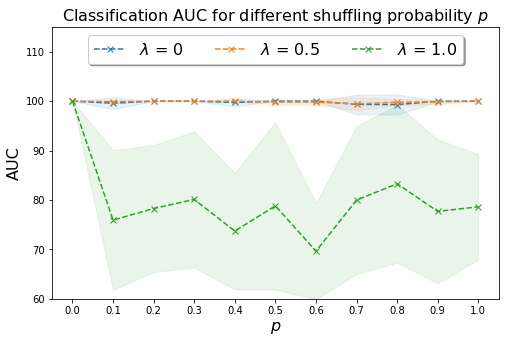

In [280]:
make_ablation_summary(res, n=10)